# Implementing an Autoencoder

> Implementing Cosine Annealing and the OneCycle scheduler from scratch

In [1]:
# |export
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import (
    Conv2dWithReLU,
    Hook,
    HooksCallback,
    StoreModuleStatsCB,
    set_seed,
)
from slowai.initializations import LSUVHook, LSUVInitialization
from slowai.learner import DeviceCB, MetricsCB, ProgressCB, TrainLearner, fashion_mnist
from slowai.sgd import BatchSchedulerCB, RecorderCB
from slowai.utils import glomf as g
from slowai.utils import show_image

In [2]:
class JReLU(nn.Module):
    def __init__(self, a=0.1, b=0.4):
        """Generalized ReLU activation function with bias and leaky slope."""
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, x):
        return F.leaky_relu(x, self.a) - self.b

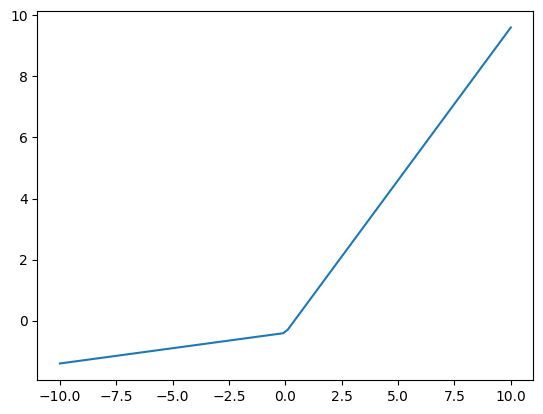

In [3]:
x = torch.linspace(-10, 10, 100)
plt.plot(x, JReLU(a=0.1, b=0.4)(x));

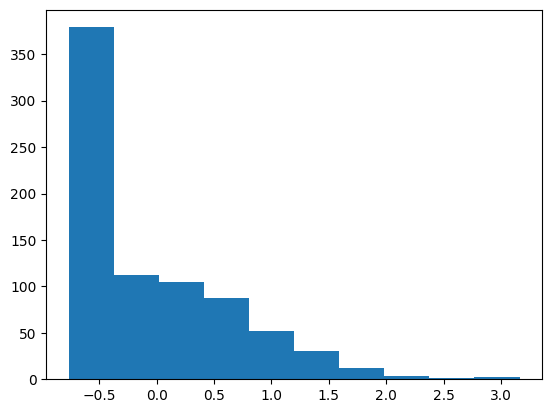

In [4]:
x = torch.randn(1, 1, 28, 28)
jrelu = JReLU(0.1)
plt.hist(jrelu(x).view(-1));

In [5]:
LEAK = 0.1


class Conv(nn.Module):
    def __init__(self, c_in, c_out, ks=3, act=JReLU(LEAK)):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, stride=2, kernel_size=ks, padding=ks // 2)
        self.act = act

    def forward(self, x):
        x = self.conv(x)
        if self.act:
            x = self.act(x)
        return x

    def forward(self, x):
        x = self.conv(x)
        if self.act:
            x = self.act(x)
        return x


class Deconv(nn.Module):
    def __init__(self, c_in, c_out, ks=3, act=JReLU(LEAK)):
        super().__init__()
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv = nn.Conv2d(c_in, c_out, stride=1, kernel_size=ks, padding=ks // 2)
        self.act = act

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        if self.act:
            x = self.act(x)
        return x

In [6]:
def apply_leaky_weights(m, neg_slope=LEAK):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, a=neg_slope)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.ModuleList(
            [
                nn.ZeroPad2d(padding=2),  # 32x32
                Conv(1, 2, ks=5),  # 16x16
                nn.BatchNorm2d(2),
                Conv(2, 4),  # 8x8
                nn.BatchNorm2d(4),
                Conv(4, 8),  # 4x4
                nn.BatchNorm2d(8),
            ]
        )
        self.decoder = nn.ModuleList(
            [
                Deconv(8, 4),  # 8x8
                nn.BatchNorm2d(4),
                Deconv(4, 2),  # 16x16
                nn.BatchNorm2d(2),
                Deconv(2, 1, act=None),  # 32x32
                nn.BatchNorm2d(1),
                nn.ZeroPad2d(padding=-2),  # 28x28
                nn.Sigmoid(),
            ]
        )

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        for layer in self.decoder:
            x = layer(x)
        return x


def get_autoencoder(initialize=True):
    ae = Autoencoder()
    if initialize:
        ae.apply(apply_leaky_weights)
    return ae


model = get_autoencoder()
model

Autoencoder(
  (encoder): ModuleList(
    (0): ZeroPad2d((2, 2, 2, 2))
    (1): Conv(
      (conv): Conv2d(1, 2, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (act): JReLU()
    )
    (2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv(
      (conv): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): JReLU()
    )
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv(
      (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): JReLU()
    )
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): ModuleList(
    (0): Deconv(
      (upsample): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): JReLU()
    )
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [7]:
dls = fashion_mnist(256)
xb, _ = dls.peek()
xb.shape, model(xb).shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 1, 28, 28]))

In [8]:
class AutoencoderLearner(TrainLearner):
    def get_loss(self):
        xb, _ = self.batch
        self.loss = F.mse_loss(self.preds, xb)


def train(model, lr, n_epochs=3, cbs=tuple()):
    """Train a Fashion MNIST model"""
    stats = StoreModuleStatsCB(mods=[*model.encoder, *model.decoder])
    cbs_ = [
        MetricsCB(),
        DeviceCB(),
        ProgressCB(plot=True),
        stats,
    ]
    if cbs:
        cbs_.extend(cbs)
    AutoencoderLearner(
        model,
        dls,
        F.mse_loss,
        lr=lr,
        cbs=cbs_,
        opt_func=torch.optim.AdamW,
    ).fit(n_epochs)
    return stats

loss,epoch,train
0.578,0,train
0.502,0,eval
0.495,1,train
0.489,1,eval
0.488,2,train
0.485,2,eval


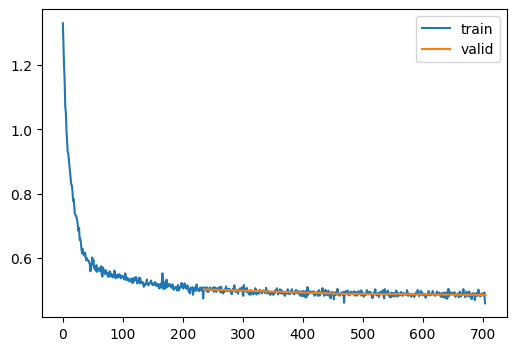

In [9]:
model = get_autoencoder()


def train_1cycle(model, cbs=[]):
    n_epochs = 3
    lr = 0.1
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(OneCycleLR, max_lr=lr, total_steps=T_max)
    return train(model, lr, n_epochs, cbs=[*cbs, scheduler])


stats = train_1cycle(model)

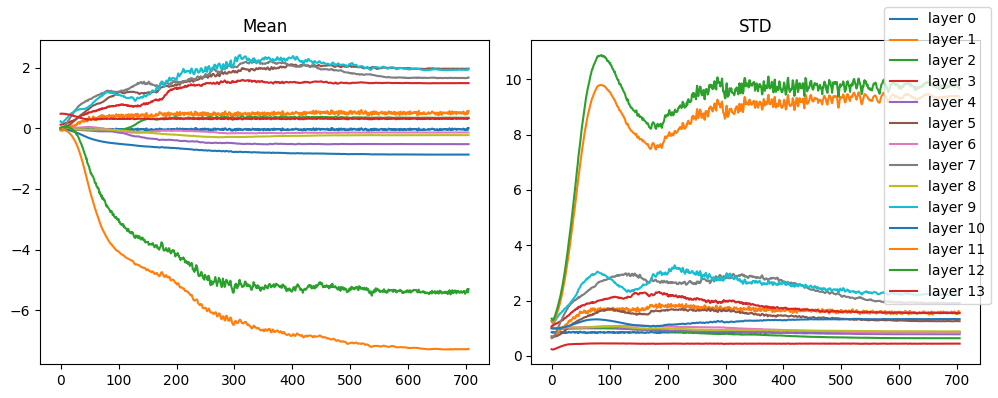

In [10]:
stats.mean_std_plot()

<Axes: >

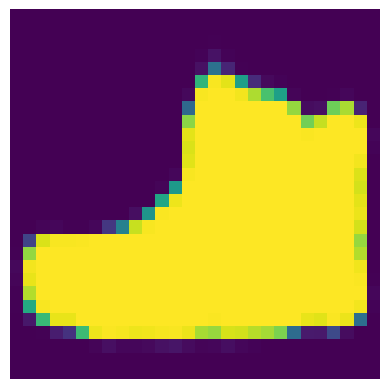

In [11]:
out = model(xb.to("cuda")).squeeze()
show_image(out[0].cpu())

In [12]:
class AELSUV(LSUVHook):
    def normalize(self):
        self.m.bias -= self.mean
        self.m.weight.data /= self.std

In [13]:
LSUVInitialization?

Init signature:
LSUVInitialization(
    mods=None,
    mod_filter=<function noop at 0x7f9cb6819b20>,
    on_train=True,
    on_valid=False,
    hook_cls=<class 'slowai.initializations.LSUVHook'>,
)
Docstring:      Layer wise sequential unit variance initialization
File:           ~/Desktop/SlowAI/nbs/slowai/initializations.py
Type:           type
Subclasses:     

Layer 0 normalized after 2 batches (-0.00, 1.00)
Layer 1 normalized after 2 batches (0.00, 1.00)
Layer 2 normalized after 2 batches (-0.00, 1.00)
Layer 3 normalized after 2 batches (0.00, 1.00)
Layer 4 normalized after 2 batches (0.00, 1.00)
Layer 5 normalized after 2 batches (-0.00, 1.00)


loss,epoch,train
0.570,0,train
0.519,0,eval
0.499,1,train
0.489,1,eval
0.489,2,train
0.487,2,eval


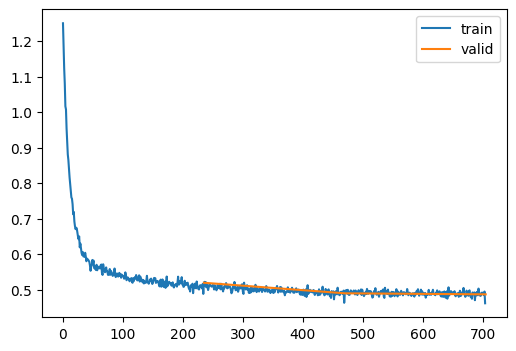

In [14]:
model = get_autoencoder(initialize=False)
convs = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
stats = train_1cycle(model, cbs=[LSUVInitialization(mods=convs, hook_cls=AELSUV)])

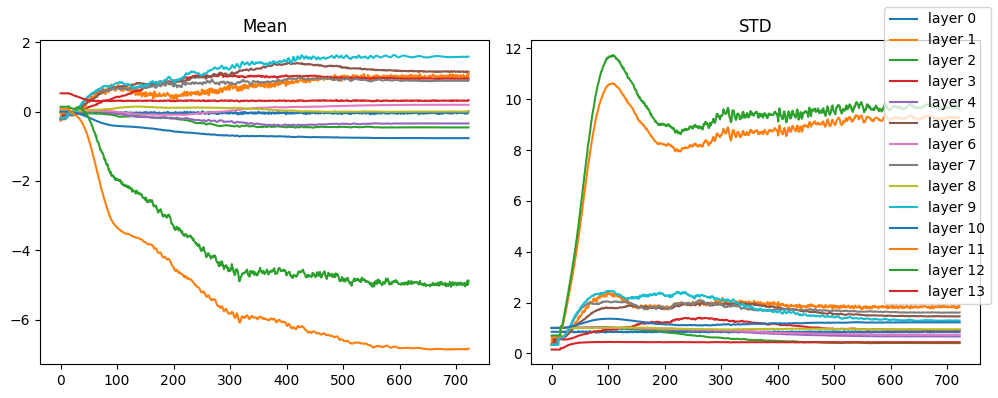

In [15]:
stats.mean_std_plot()

<Axes: >

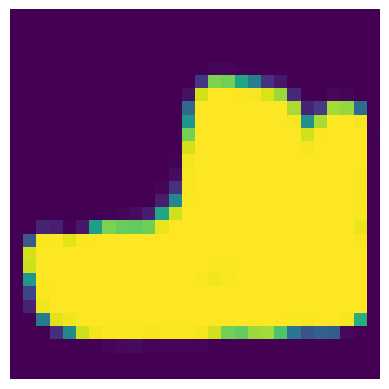

In [16]:
out = model(xb.to("cuda")).squeeze()
show_image(out[0].cpu())